# 🖼️ Introduction to Multimodal RAG

In this notebook, you'll learn how to index and retrieve images using Haystack. By the end, you'll be able to build a Retrieval-Augmented Generation (RAG) pipeline that can answer questions grounded in both images and text. This is useful when working with datasets like scientific papers, diagrams, or screenshots where meaning is spread across modalities.

This tutorial uses the following **new components** that enable image indexing:

- `SentenceTransformersDocumentImageEmbedder`: Embed image documents with CLIP-based models
- `ImageFileToDocument`: Convert image files into Haystack `Document`s
- `DocumentTypeRouter`: Route retrieved documents by mime type (e.g., image vs text)
- `DocumentToImageContent`: Convert image documents into `ImageContent` to be processed by our ChatGenerator
- `LLMDocumentContentExtractor`: Extracts textual content from image-based documents using a vision-enabled LLM.

In this notebook, we'll introduce all these features, show an application using **image + text retrieval + multimodal generation**.

## Setup Development Environment

In [ ]:
!pip install --upgrade "haystack-experimental" pillow pypdfium2

In [1]:
import os
from getpass import getpass
from pprint import pp as print


if "OPENAI_API_KEY" not in os.environ:
  os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

Enter OpenAI API key: ········


## Introduction to Embedding Images

Let's compare the similarity between a text and two images.

First let's download two sample images, one of an apple and one of a Capybara.

In [ ]:
!wget "https://upload.wikimedia.org/wikipedia/commons/2/26/Pink_Lady_Apple_%284107712628%29.jpg" -O apple.jpg
!wget "https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/Cattle_tyrant_%28Machetornis_rixosa%29_on_Capybara.jpg/960px-Cattle_tyrant_%28Machetornis_rixosa%29_on_Capybara.jpg?download" -O capybara.jpg


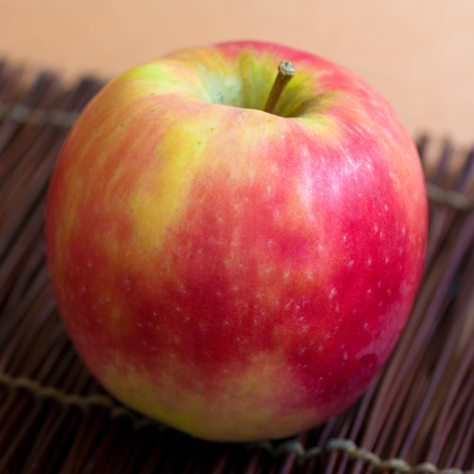

In [14]:
from PIL import Image
img = Image.open("apple.jpg")
# We resize the image here just to avoid it taking up too much space in the notebook
img_resized = img.resize((img.width // 6, img.height // 6))
img_resized

Next we convert our Image Files into Haystack Documents so they can be used downstream in our **SentenceTransformersDocumentImageEmbedder** component. 

In [4]:
from haystack_experimental.components.converters.image import ImageFileToDocument

image_file_converter = ImageFileToDocument()
image_docs = image_file_converter.run(sources=["apple.jpg", "capybara.jpg"])["documents"]
print(image_docs)

[Document(id=ab81e5b007d0016dc2221538326671e672f4f88f12abc4eae624332cf8dc812e, meta: {'file_path': 'apple.jpg'}), Document(id=ff6efc0b376f144dd8cc665bffb167407f6db031d4b3a408847d05d452124bca, meta: {'file_path': 'capybara.jpg'})]


Next we load our embedders. It's important that we use the same CLIP model for both text and images.

In [ ]:
from haystack.components.embedders.sentence_transformers_text_embedder import SentenceTransformersTextEmbedder
from haystack_experimental.components.embedders.image.sentence_transformers_doc_image_embedder import (
    SentenceTransformersDocumentImageEmbedder,
)

text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/clip-ViT-L-14", progress_bar=False)
image_embedder = SentenceTransformersDocumentImageEmbedder(model="sentence-transformers/clip-ViT-L-14", progress_bar=False)

# Warm up the models to load them
text_embedder.warm_up()
image_embedder.warm_up()

Let's run the embedders and see how semantically similar our query is with our two images.

In [6]:
import torch
from sentence_transformers import util

query = "A red apple on a white background"
text_embedding = text_embedder.run(text=query)["embedding"]
image_docs_with_embeddings = image_embedder.run(image_docs)["documents"]

# Compare the similarities between the query and two image documents
for doc in image_docs_with_embeddings:
    similarity = util.cos_sim(torch.tensor(text_embedding), torch.tensor(doc.embedding))
    print(f"Similarity with {doc.meta['file_path'].split('/')[-1]}: {similarity.item():.2f}")

Similarity with apple.jpg: 0.27
Similarity with capybara.jpg: 0.07


As we can see the text is most similar to our Apple image!

# Multimodal RAG Search Part I.

First let's also download a sample PDF file to see how we can retrieve over both text and image based documents

In [ ]:
!wget https://arxiv.org/pdf/1706.03762.pdf -O attention_is_all_you_need.pdf


## Building an Image + Text Indexing Pipeline

Next let's create an indexing pipeline to process all of our files at once and write them to our Document Store.

So in the following Pipeline we are:
- computing embeddings based on images for image files
- converting PDF files to textual Documents and then computing embeddings based on the text

### Manually Embed Text and Image Documents

In [20]:
# Imports
from haystack import Pipeline
from haystack.components.converters.pypdf import PyPDFToDocument
from haystack.components.embedders.sentence_transformers_document_embedder import SentenceTransformersDocumentEmbedder
from haystack.components.joiners import DocumentJoiner
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.routers.file_type_router import FileTypeRouter
from haystack.components.writers.document_writer import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore

In [23]:
# Create our document store
doc_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

# Define our components
file_type_router = FileTypeRouter(mime_types=["application/pdf", "image/jpeg"])
final_doc_joiner = DocumentJoiner(sort_by_score=False)
image_converter = ImageFileToDocument()
pdf_converter = PyPDFToDocument()
pdf_splitter = DocumentSplitter(split_by="page", split_length=1)
text_doc_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/clip-ViT-L-14", progress_bar=False)
image_embedder = SentenceTransformersDocumentImageEmbedder(model="sentence-transformers/clip-ViT-L-14", progress_bar=False)
document_writer = DocumentWriter(doc_store)

In [24]:
# Create the Indexing Pipeline
indexing_pipe = Pipeline()
indexing_pipe.add_component("file_type_router", file_type_router)
indexing_pipe.add_component("pdf_converter", pdf_converter)
indexing_pipe.add_component("pdf_splitter", pdf_splitter)
indexing_pipe.add_component("image_converter", image_converter)
indexing_pipe.add_component("text_doc_embedder", text_doc_embedder)
indexing_pipe.add_component("image_doc_embedder", image_embedder)
indexing_pipe.add_component("final_doc_joiner", final_doc_joiner)
indexing_pipe.add_component("document_writer", document_writer)

indexing_pipe.connect("file_type_router.application/pdf", "pdf_converter.sources")
indexing_pipe.connect("pdf_converter.documents", "pdf_splitter.documents")
indexing_pipe.connect("pdf_splitter.documents", "text_doc_embedder.documents")
indexing_pipe.connect("file_type_router.image/jpeg", "image_converter.sources")
indexing_pipe.connect("image_converter.documents", "image_doc_embedder.documents")
indexing_pipe.connect("text_doc_embedder.documents", "final_doc_joiner.documents")
indexing_pipe.connect("image_doc_embedder.documents", "final_doc_joiner.documents")
indexing_pipe.connect("final_doc_joiner.documents", "document_writer.documents")

🚅 Components
  - file_type_router: FileTypeRouter
  - pdf_converter: PyPDFToDocument
  - pdf_splitter: DocumentSplitter
  - image_converter: ImageFileToDocument
  - text_doc_embedder: SentenceTransformersDocumentEmbedder
  - image_doc_embedder: SentenceTransformersDocumentImageEmbedder
  - final_doc_joiner: DocumentJoiner
  - document_writer: DocumentWriter
🛤️ Connections
  - file_type_router.application/pdf -> pdf_converter.sources (List[Union[str, Path, ByteStream]])
  - file_type_router.image/jpeg -> image_converter.sources (List[Union[str, Path, ByteStream]])
  - pdf_converter.documents -> pdf_splitter.documents (List[Document])
  - pdf_splitter.documents -> text_doc_embedder.documents (List[Document])
  - image_converter.documents -> image_doc_embedder.documents (List[Document])
  - text_doc_embedder.documents -> final_doc_joiner.documents (List[Document])
  - image_doc_embedder.documents -> final_doc_joiner.documents (List[Document])
  - final_doc_joiner.documents -> document_wri

Visualize the Indexing pipeline

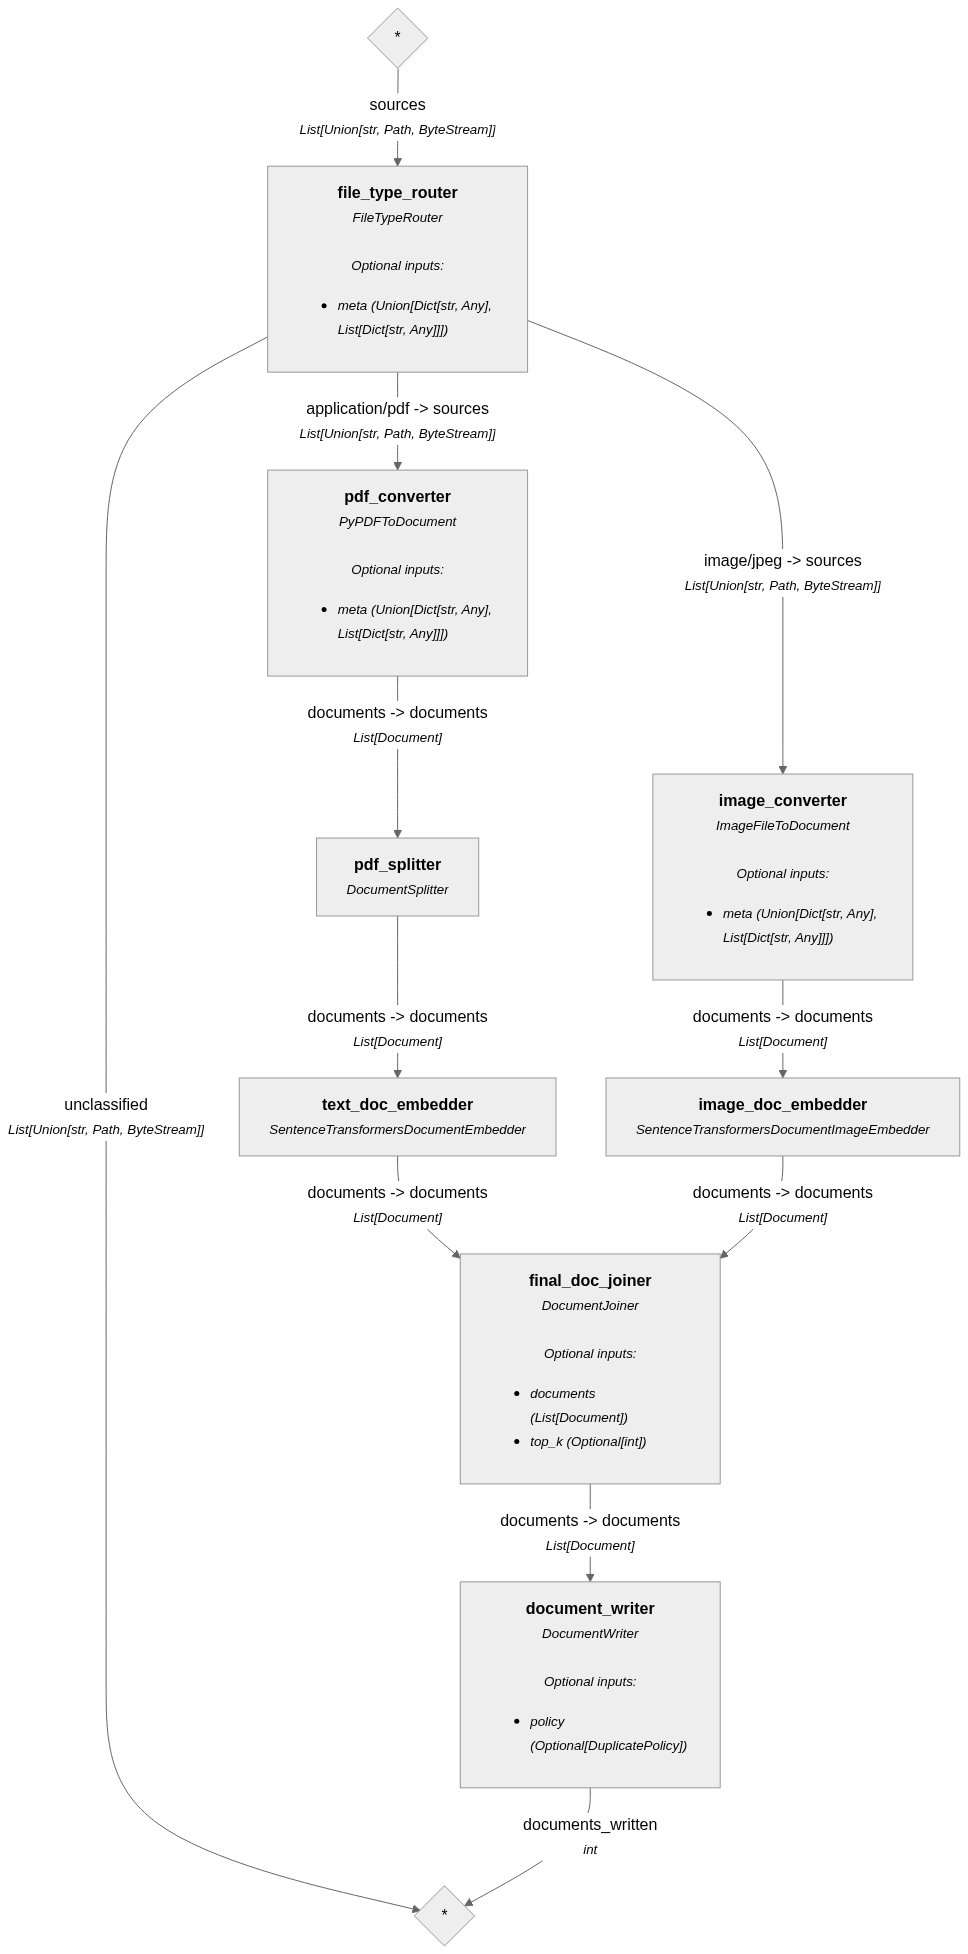

In [26]:
indexing_pipe.show()

Run the indexing pipeline

In [27]:
indexing_result = indexing_pipe.run(
    data={"file_type_router": {"sources": ["attention_is_all_you_need.pdf", "apple.jpg"]}},
)

Inspect the documents

In [30]:
indexed_documents = doc_store.filter_documents()
print(f"Indexed {len(indexed_documents)} documents")

Indexed 16 documents


## Multimodal Retrieval - Searching Image + Text

In [43]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

retriever = InMemoryEmbeddingRetriever(document_store=doc_store)
text_embedding = text_embedder.run(text="An image of an apple")["embedding"]
results = retriever.run(text_embedding)['documents']

for idx, doc in enumerate(results[:5]):
    print(f"Document {idx+1}:")
    print(f"Score: {doc.score}")
    print(f"File Path: {doc.meta['file_path']}")
    print()

Document 1:
Score: 0.5757899940721912
File Path: attention_is_all_you_need.pdf

Document 2:
Score: 0.5757899940721912
File Path: attention_is_all_you_need.pdf

Document 3:
Score: 0.5112776601571599
File Path: attention_is_all_you_need.pdf

Document 4:
Score: 0.500057274922339
File Path: attention_is_all_you_need.pdf

Document 5:
Score: 0.4852181778467957
File Path: attention_is_all_you_need.pdf



Huh how odd! It doesn't seem like any of the top results are relevant. In fact it seems like the top retrieved documents are text-based no matter how irrelevant they are.

This is actually a common scenario when trying to run Mutimodal RAG with both images and text at the same time. Often times the underlying embedding model (CLIP in this case) is not trained to handle both text and image documents at the same time and can be biased towards one type. In this case the model we have chosen appears to be biased towards text to text similarities which we can observe by the scores attached to each Document.

Side Note: It's possible more recent models like [jina-embeddings-v4](https://huggingface.co/jinaai/jina-embeddings-v4) or [Cohere Embed 4](https://cohere.com/blog/embed-4) might work better for this type of scenario.

To combat this let's use a slightly different approach below.

# Multimodal RAG Search Part II.

In this approach we will use the `LLMDocumentContentExtractor` to first extract a textual representation of all images before writing them to our DocumentStore.

- This will allow us to use text-only retrieval methods when searching through our DocumentStore.
- **But** we will still send the actual image to the Vision LLM. This is helpful since it's possible that the image contains more information and nuance than the extracted version. 

## Image + Text Indexing Pipeline using the LLMDocumentContentExtractor

In [2]:
from haystack import Pipeline
from haystack.components.converters.pypdf import PyPDFToDocument
from haystack.components.embedders.sentence_transformers_document_embedder import SentenceTransformersDocumentEmbedder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.joiners import DocumentJoiner
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.routers.file_type_router import FileTypeRouter
from haystack.components.writers.document_writer import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore

from haystack_experimental.components.converters.image import ImageFileToDocument
from haystack_experimental.components.extractors import LLMDocumentContentExtractor

In [3]:
# Create our document store
doc_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

# Define our components
file_type_router = FileTypeRouter(mime_types=["application/pdf", "image/jpeg"])
image_converter = ImageFileToDocument()
pdf_converter = PyPDFToDocument()
pdf_splitter = DocumentSplitter(split_by="page", split_length=1)
final_doc_joiner = DocumentJoiner(sort_by_score=False)
document_writer = DocumentWriter(doc_store)

# Now we use high-performing text-only embedders
doc_embedder = SentenceTransformersDocumentEmbedder(
    model="mixedbread-ai/mxbai-embed-large-v1", progress_bar=False
)

# New LLMDocumentContentExtractor
llm_content_extractor = LLMDocumentContentExtractor(
    chat_generator=OpenAIChatGenerator(model="gpt-4o-mini"),
    max_workers=1,  # This can be used to parallelize the content extraction
)

In [4]:
# Create the Indexing Pipeline
indexing_pipe = Pipeline()
indexing_pipe.add_component("file_type_router", file_type_router)
indexing_pipe.add_component("pdf_converter", pdf_converter)
indexing_pipe.add_component("pdf_splitter", pdf_splitter)
indexing_pipe.add_component("image_converter", image_converter)
indexing_pipe.add_component("llm_content_extractor", llm_content_extractor)
indexing_pipe.add_component("doc_embedder", doc_embedder)
indexing_pipe.add_component("final_doc_joiner", final_doc_joiner)
indexing_pipe.add_component("document_writer", document_writer)

indexing_pipe.connect("file_type_router.application/pdf", "pdf_converter.sources")
indexing_pipe.connect("pdf_converter.documents", "pdf_splitter.documents")
indexing_pipe.connect("pdf_splitter.documents", "final_doc_joiner.documents")
indexing_pipe.connect("file_type_router.image/jpeg", "image_converter.sources")
indexing_pipe.connect("image_converter.documents", "llm_content_extractor.documents")
indexing_pipe.connect("llm_content_extractor.documents", "final_doc_joiner.documents")
indexing_pipe.connect("final_doc_joiner.documents", "doc_embedder.documents")
indexing_pipe.connect("doc_embedder.documents", "document_writer.documents")

🚅 Components
  - file_type_router: FileTypeRouter
  - pdf_converter: PyPDFToDocument
  - pdf_splitter: DocumentSplitter
  - image_converter: ImageFileToDocument
  - llm_content_extractor: LLMDocumentContentExtractor
  - doc_embedder: SentenceTransformersDocumentEmbedder
  - final_doc_joiner: DocumentJoiner
  - document_writer: DocumentWriter
🛤️ Connections
  - file_type_router.application/pdf -> pdf_converter.sources (List[Union[str, Path, ByteStream]])
  - file_type_router.image/jpeg -> image_converter.sources (List[Union[str, Path, ByteStream]])
  - pdf_converter.documents -> pdf_splitter.documents (List[Document])
  - pdf_splitter.documents -> final_doc_joiner.documents (List[Document])
  - image_converter.documents -> llm_content_extractor.documents (List[Document])
  - llm_content_extractor.documents -> final_doc_joiner.documents (List[Document])
  - doc_embedder.documents -> document_writer.documents (List[Document])
  - final_doc_joiner.documents -> doc_embedder.documents (List[

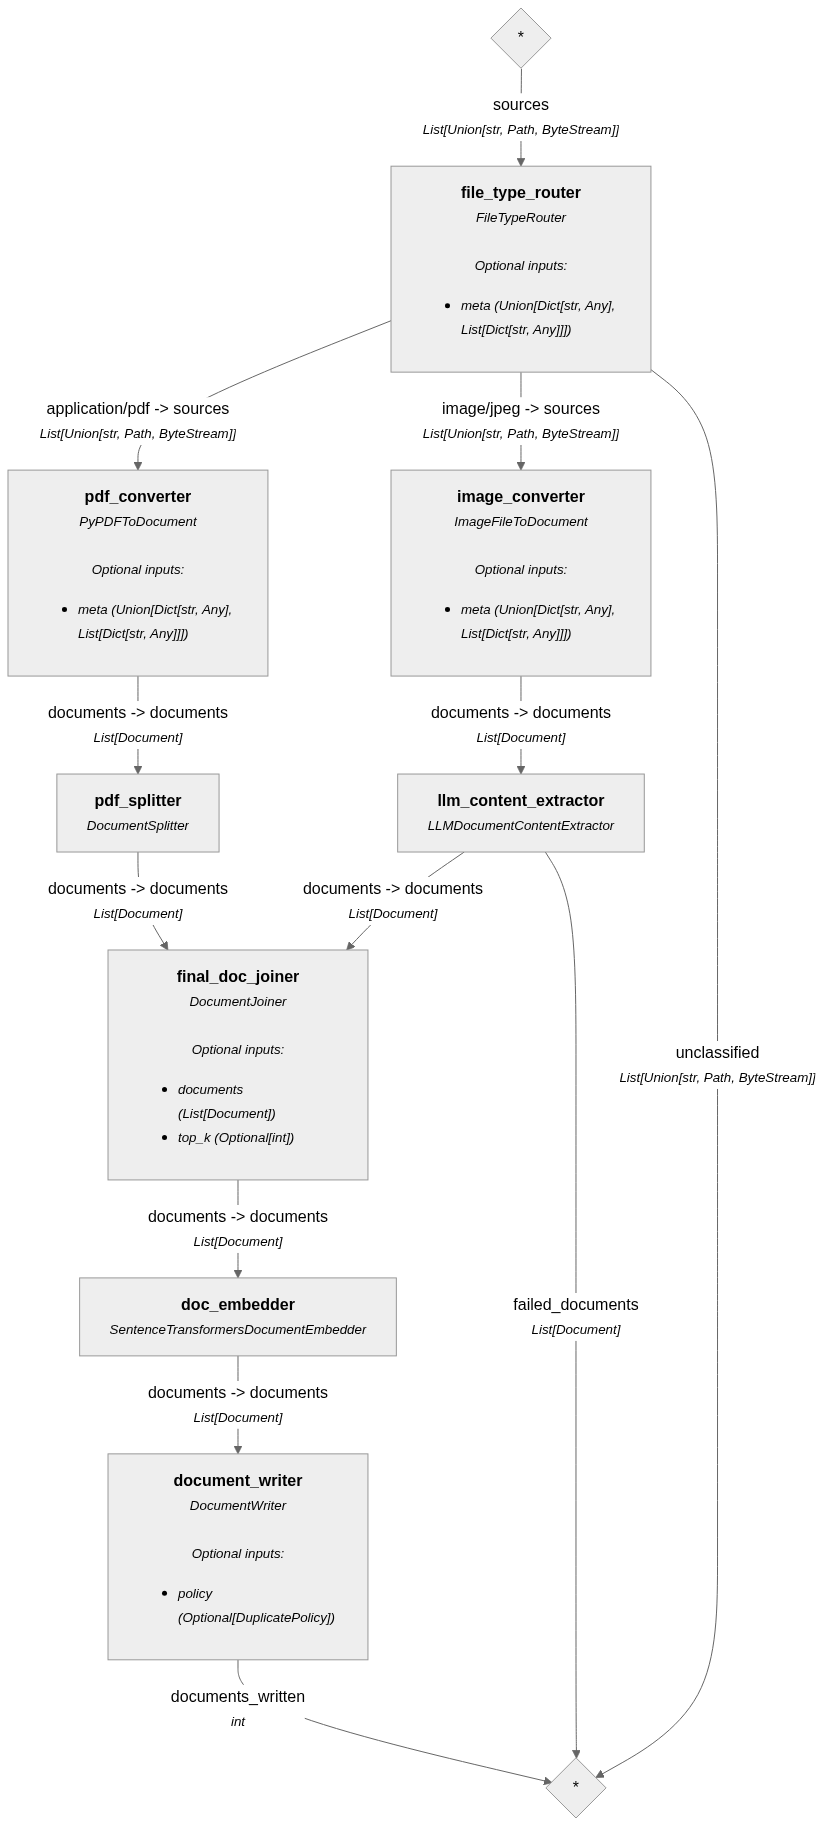

In [8]:
indexing_pipe.show()

In [5]:
indexing_result = indexing_pipe.run(
    data={"file_type_router": {"sources": ["attention_is_all_you_need.pdf", "apple.jpg"]}},
)

In [6]:
indexed_documents = doc_store.filter_documents()
print(f"Indexed {len(indexed_documents)} documents")

'Indexed 16 documents'


Let's inspect our image document to see what content was extracted

In [11]:
image_doc = [d for d in indexed_documents if d.meta.get('file_path') == 'apple.jpg']
image_doc

[Document(id=ab81e5b007d0016dc2221538326671e672f4f88f12abc4eae624332cf8dc812e, content: '[img-caption]A close-up image of a red and yellow apple resting on a brown woven surface.[/img-capti...', meta: {'file_path': 'apple.jpg'}, embedding: vector of size 1024)]

We have a an image caption (i.e. an image caption) of our image of an apple! 

We can now use this image caption to retrieve the image document at query time **and** still use the image to answer a user's question.

## Multimodal RAG on Image + Text

In [13]:
from haystack import Pipeline
from haystack.components.embedders.sentence_transformers_text_embedder import SentenceTransformersTextEmbedder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.retrievers.in_memory.embedding_retriever import InMemoryEmbeddingRetriever

from haystack_experimental.components.builders import ChatPromptBuilder
from haystack_experimental.components.converters.image import DocumentToImageContent
from haystack_experimental.components.routers import DocumentTypeRouter

In [14]:
# Define our components
text_embedder = SentenceTransformersTextEmbedder(
    model="mixedbread-ai/mxbai-embed-large-v1",
    progress_bar=False
)
retriever = InMemoryEmbeddingRetriever(document_store=doc_store, top_k=3)
doc_type_router = DocumentTypeRouter(
    file_path_meta_field="file_path",
    mime_types=["image/jpeg", "application/pdf"]
)
doc_to_image = DocumentToImageContent(detail="auto")
chat_prompt_builder = ChatPromptBuilder(
    required_variables=["question"],
    template="""{% message role="system" %}
You are a friendly assistant that answers questions based on provided documents and images.
{% endmessage %}

{%- message role="user" -%}
Only provide an answer to the question using the images and text passages provided.

These are the text-only documents:
{%- if documents|length > 0 %}
{%- for doc in text_documents %}
Text Document [{{ loop.index }}] :
{{ doc.content }}
{% endfor -%}
{%- else %}
No relevant text documents were found.
{% endif %}
End of text documents.


Question: {{ question }}
Answer:

{%- if image_contents|length > 0 %}
{%- for img in image_contents -%}
  {{ img | templatize_part }}
{%- endfor -%}
{% endif %}
{%- endmessage -%}
""",
)
llm = OpenAIChatGenerator(model="gpt-4o-mini")

In [15]:
# Create the Query Pipeline
pipe = Pipeline()
pipe.add_component("text_embedder", text_embedder)
pipe.add_component("retriever", retriever)
pipe.add_component("doc_type_router", doc_type_router)
pipe.add_component("doc_to_image", doc_to_image)
pipe.add_component("chat_prompt_builder", chat_prompt_builder)
pipe.add_component("llm", llm)

pipe.connect("text_embedder.embedding", "retriever.query_embedding")
pipe.connect("retriever.documents", "doc_type_router.documents")
pipe.connect("doc_type_router.image/jpeg", "doc_to_image.documents")
pipe.connect("doc_to_image.image_contents", "chat_prompt_builder.image_contents")
pipe.connect("doc_type_router.application/pdf", "chat_prompt_builder.documents")
pipe.connect("chat_prompt_builder.prompt", "llm.messages")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - doc_type_router: DocumentTypeRouter
  - doc_to_image: DocumentToImageContent
  - chat_prompt_builder: ChatPromptBuilder
  - llm: OpenAIChatGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> doc_type_router.documents (List[Document])
  - doc_type_router.image/jpeg -> doc_to_image.documents (List[Document])
  - doc_type_router.application/pdf -> chat_prompt_builder.documents (List[Document])
  - doc_to_image.image_contents -> chat_prompt_builder.image_contents (List[Optional[ImageContent]])
  - chat_prompt_builder.prompt -> llm.messages (List[ChatMessage])

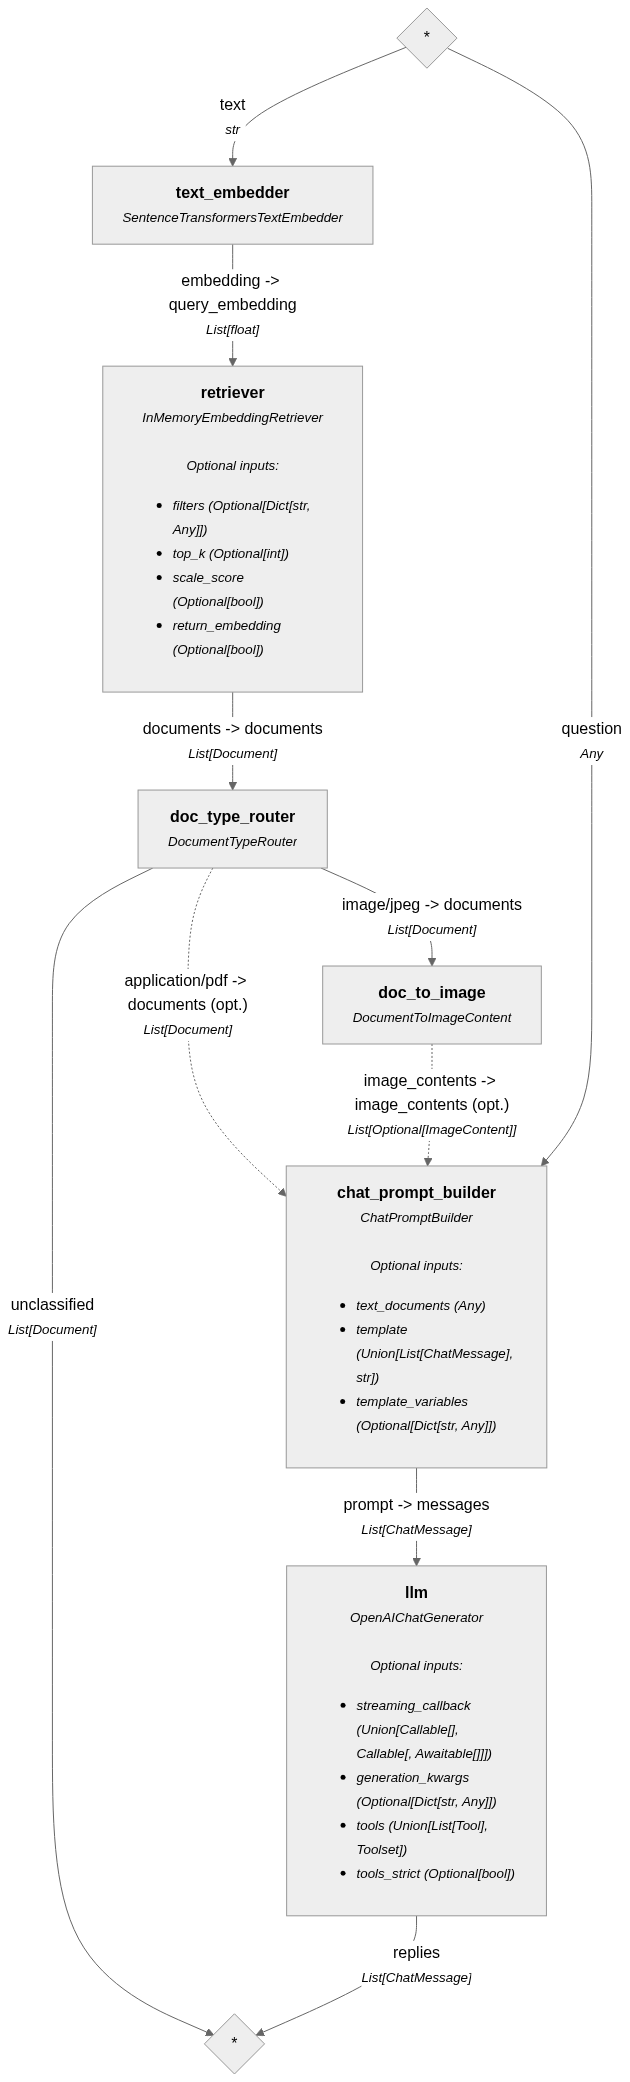

In [16]:
pipe.show()

In [27]:
# Run the pipeline with a query about the apple
query = "What is the color of the background of the image with an apple in it?"
result = pipe.run(
    data={"text_embedder": {"text": query}, "chat_prompt_builder": {"question": query}},
    include_outputs_from={"retriever"},
)
print(result["llm"]["replies"][0].text)

The color of the background of the image with the apple is a light brown.


And now we can see that the document representing the apple.jpg file was retrieved first!

In [26]:
for idx, doc in enumerate(result["retriever"]["documents"]):
    print(f"Document {idx+1}:")
    print(f"Score: {doc.score}")
    print(f"File Path: {doc.meta['file_path']}")
    print()

Document 1:
Score: 0.824359100095525
File Path: apple.jpg

Document 2:
Score: 0.48105969439753216
File Path: attention_is_all_you_need.pdf

Document 3:
Score: 0.43121766632034
File Path: attention_is_all_you_need.pdf



In [29]:
# Run the pipeline with a query about the pdf document
query = "What is attention in the transformers architecture?"
result = pipe.run(
    data={"text_embedder": {"text": query}, "chat_prompt_builder": {"question": query}}
)
print(result["llm"]["replies"][0].text)

Attention in the transformers architecture is a mechanism that allows the model to weigh the importance of different words or tokens in a sequence when processing input data. It enables the model to focus on relevant parts of the input when making predictions or generating outputs, effectively capturing relationships and context in the data.


## What's next?

You can follow the progress of the Multimodal experiment in this [GitHub issue](https://github.com/deepset-ai/haystack/issues/8976).

(*Notebook by [Sebastian Husch Lee](https://github.com/sjrl)*)